In [1]:
# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

# Plotting imports and settings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = "."

imgpath = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(imgpath):
    os.makedirs(imgpath)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Volume Sold & Time
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# IowaSales_Copy_Filled
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# LSTM neural network training related parameters 
past_history = 360
future_target = 60
n_neurons = [32, 16]
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200 # Not to big to avoid too slow
EPOCHS = 10

## Load

In [5]:
isLocal = True

filename = "IowaSales_cleanedandprepped.csv"
google_drv_path = "C:/Users/tirth/Downloads/"
local_path = "C:/Users/tirth/Downloads/"
if not isLocal: 
  !pip install -U -q PyDrive
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)
  full_filepath = google_drv_path + filename
else:
  full_filepath = local_path + filename 

In [6]:
%%time
IowaSales = pd.read_csv(full_filepath, low_memory=False, parse_dates=True)
IowaSales.shape

Wall time: 39.8 s


(23973220, 21)

In [7]:
size = IowaSales.shape[0]
if(pd.options.display.max_info_rows <= size):
  pd.options.display.max_info_rows = size + 1
pd.options.display.max_rows = 500
print(pd.options.display.max_info_rows)

23973221


In [8]:
IowaSales['Date'] = pd.to_datetime(IowaSales['Date'])
IowaSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23973220 entries, 0 to 23973219
Data columns (total 21 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   Date                   23973220 non-null  datetime64[ns]
 1   Store Number           23973220 non-null  int64         
 2   City                   23973220 non-null  object        
 3   Zip Code               23973220 non-null  int64         
 4   County Number          23973220 non-null  float64       
 5   Category               23973220 non-null  float64       
 6   Category Name          23973220 non-null  object        
 7   Vendor Number          23973220 non-null  float64       
 8   Item Number            23973220 non-null  int64         
 9   Pack                   23973220 non-null  int64         
 10  Bottle Volume (ml)     23973220 non-null  int64         
 11  State Bottle Cost      23973220 non-null  float64       
 12  State Bottle

In [9]:
IowaSales.head()

,Date,Store Number,City,Zip Code,County Number,Category,Category Name,Vendor Number,Item Number,Pack,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Longitude,Latitude,Month,Pack Volume (ml)
0,2014-04-09,3869,CORALVILLE,52241,52.0,1032080.0,VODKA,305.0,34244,6,...,15.83,23.74,6,142.44,4.5,1.19,-91.565517,41.672672,4,4500
1,2015-02-23,3612,MAQUOKETA,52060,49.0,1081400.0,CORDIALS & LIQUEURS,421.0,86637,12,...,3.01,4.52,3,13.56,3.0,0.79,-90.659692,42.069220,2,12000
2,2014-05-29,2509,CEDAR RAPIDS,52404,57.0,1012100.0,WHISKY,115.0,11774,24,...,3.07,4.60,24,110.40,9.0,2.38,-91.677060,41.962419,5,9000
3,2014-09-16,2228,WINTERSET,50273,61.0,1081380.0,SCHNAPPS,65.0,73517,12,...,7.62,11.43,1,11.43,1.0,0.26,-94.013374,41.336405,9,12000
4,2012-10-31,4805,FORT DODGE,50501,94.0,1022100.0,TEQUILA,434.0,89386,12,...,6.29,9.43,2,18.86,1.5,0.40,-94.186138,42.506332,10,9000


In [10]:
# One Hot encoder - converting 
IowaSales_Copy = pd.get_dummies(IowaSales, columns=["Category Name"], prefix_sep='_', drop_first=True)
IowaSales_Copy = pd.get_dummies(IowaSales_Copy, columns=["County Number"], prefix_sep='_', drop_first=True)


In [12]:
IowaSales_Reduced = IowaSales_Copy.drop(
    ['City', 'Category', 'Zip Code', 'Vendor Number', 'Store Number', 'Item Number', 'Volume Sold (Gallons)', 'State Bottle Retail', 'Longitude'], 
    axis=1)

In [13]:
IowaSales_Reduced.columns[:].to_list()

['Date',
 'Pack',
 'Bottle Volume (ml)',
 'State Bottle Cost',
 'Bottles Sold',
 'Sale (Dollars)',
 'Volume Sold (Liters)',
 'Latitude',
 'Month',
 'Pack Volume (ml)',
 'Category Name_ANISETTE',
 'Category Name_BEER',
 'Category Name_BRANDIES',
 'Category Name_COCKTAIL',
 'Category Name_CORDIALS & LIQUEURS',
 'Category Name_DELISTED / SPECIAL ORDER ITEMS',
 'Category Name_GINS',
 'Category Name_IOWA DISTILLERIES',
 'Category Name_MEZCAL',
 'Category Name_OTHERS',
 'Category Name_ROCK & RYE',
 'Category Name_RUM',
 'Category Name_SCHNAPPS',
 'Category Name_SCOTCH',
 'Category Name_SPECIAL ORDER ITEMS',
 'Category Name_SPIRIT SPECIALTY',
 'Category Name_TEQUILA',
 'Category Name_VODKA',
 'Category Name_WHISKY',
 'County Number_2.0',
 'County Number_3.0',
 'County Number_4.0',
 'County Number_5.0',
 'County Number_6.0',
 'County Number_7.0',
 'County Number_8.0',
 'County Number_9.0',
 'County Number_10.0',
 'County Number_11.0',
 'County Number_12.0',
 'County Number_13.0',
 'County Numb

In [14]:
from sklearn.model_selection import train_test_split
IowaSales_Main = IowaSales_Copy.copy()
# y_Sale = IowaSales_Main[['Sale (Dollars)']].values
# X_Sale = IowaSales_Main.drop(['Sale (Dollars)', 'City'], axis=1).values
# X_Sale_train, X_Sale_test, y_Sale_train, y_Sale_test = train_test_split(X_Sale, y_Sale)

Saving figure attribute_histogram_plots_filled


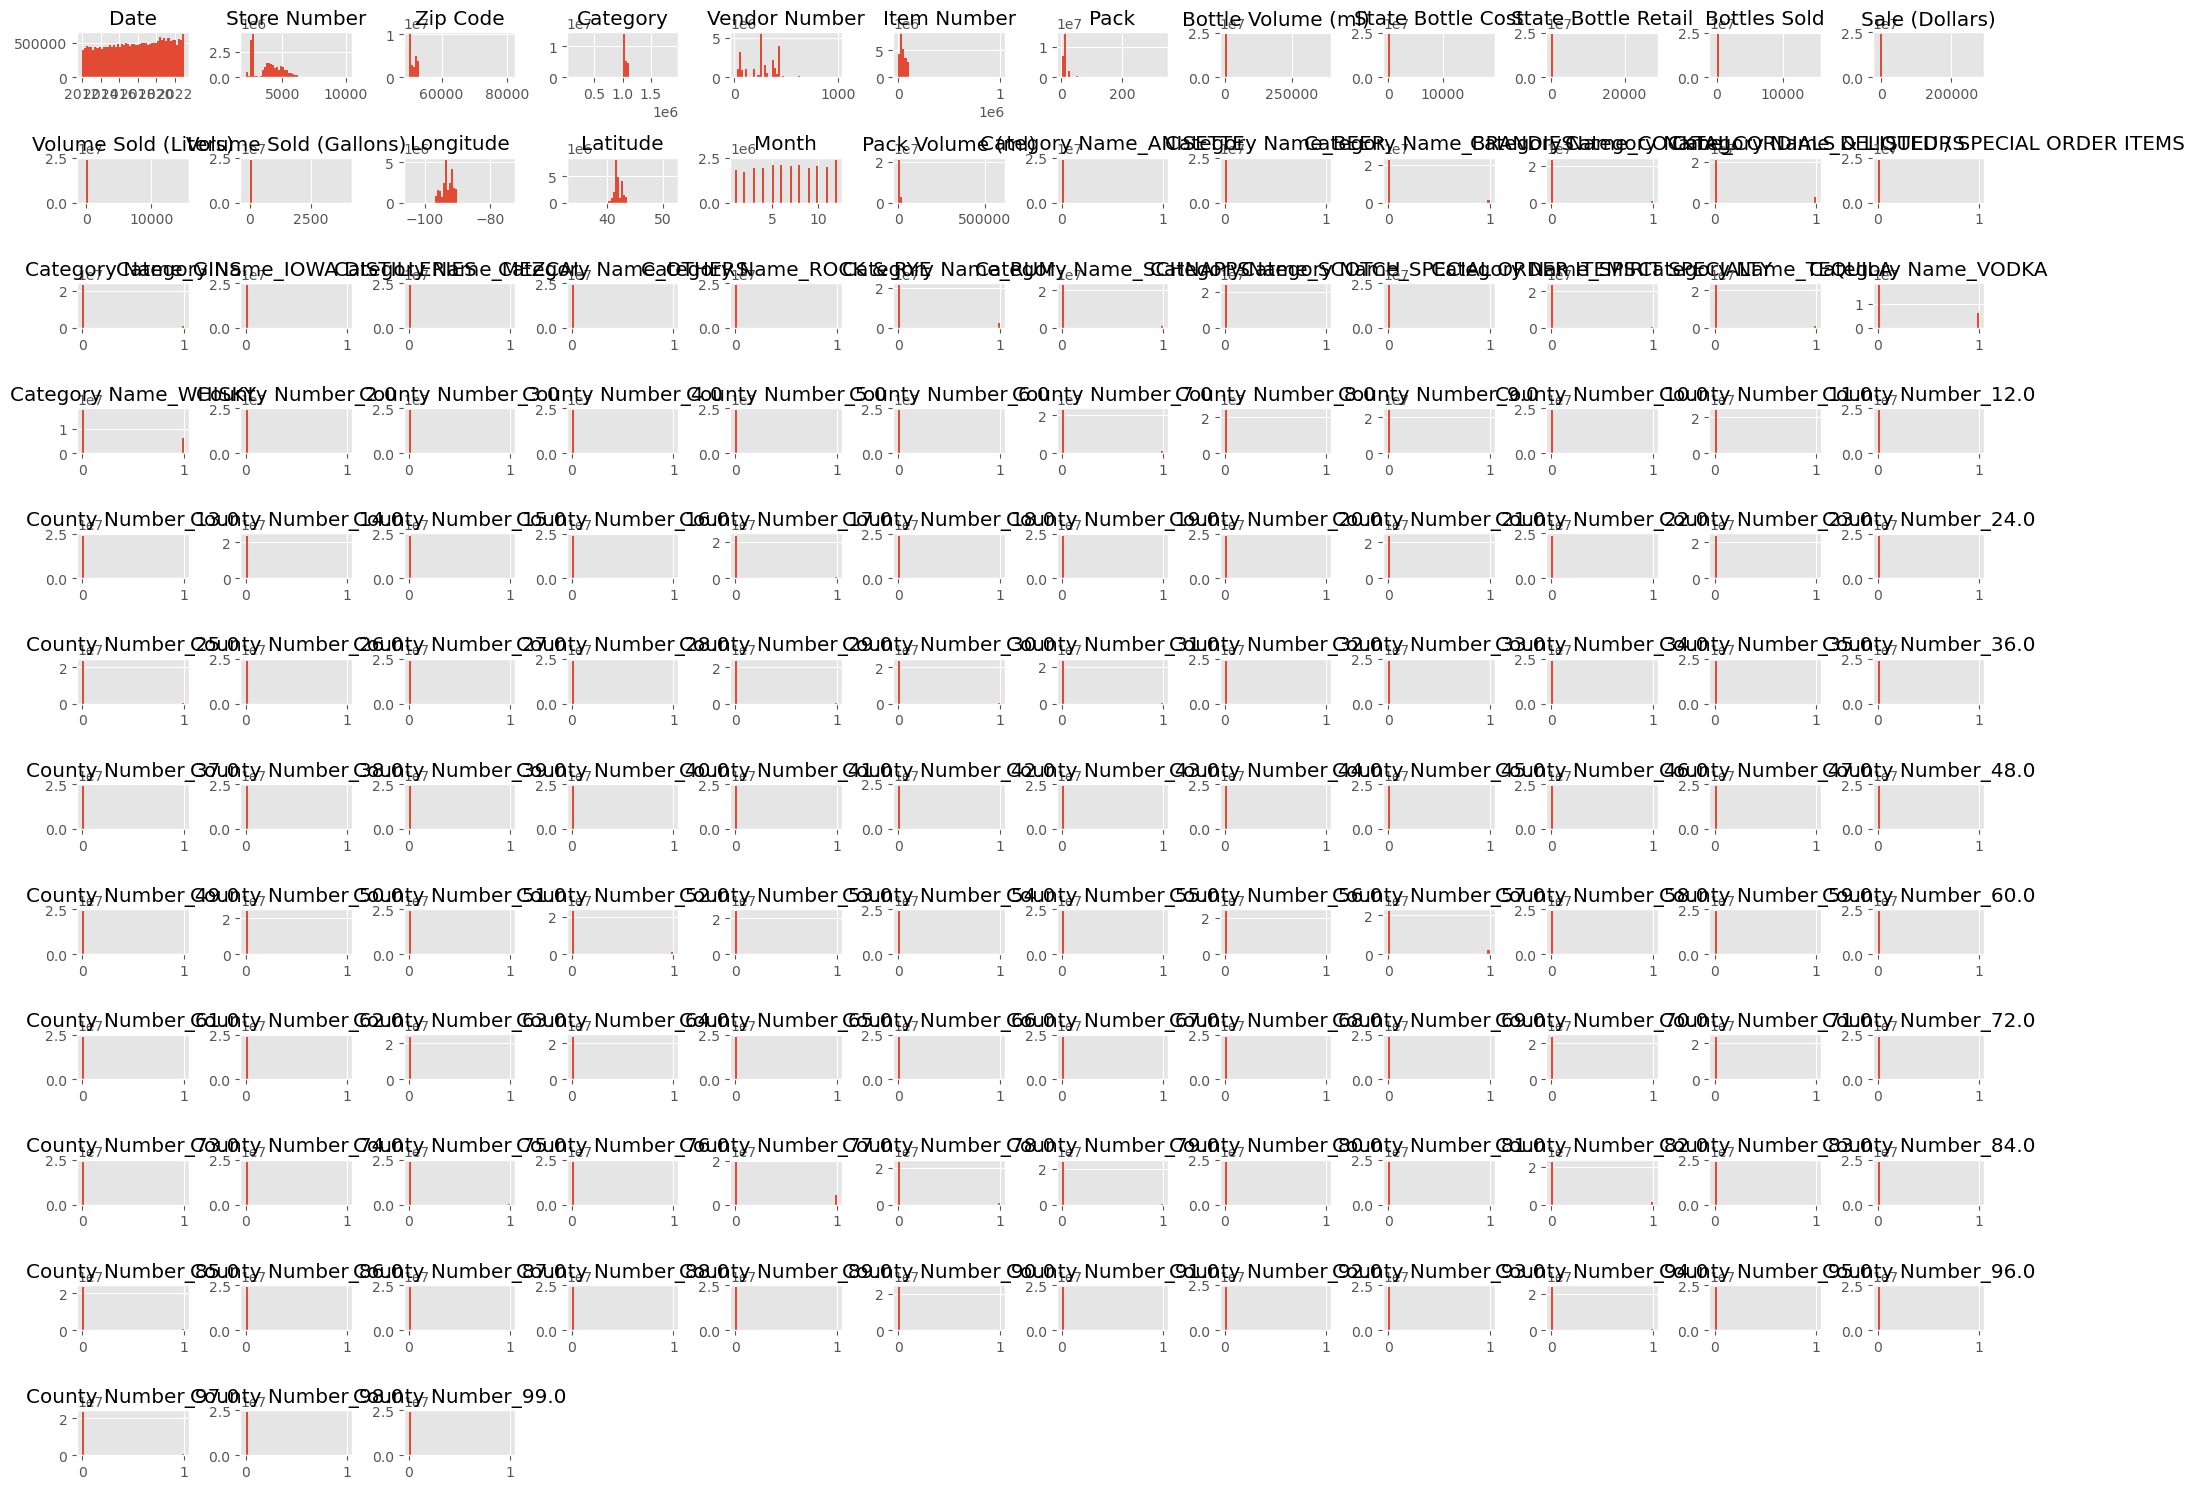

In [15]:
# %matplotlib inline
# import matplotlib.pyplot as plt
IowaSales_Main.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots_filled")
plt.show()

## Model

In [16]:
IowaSales_Reduced.head()

,Date,Pack,Bottle Volume (ml),State Bottle Cost,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Latitude,Month,Pack Volume (ml),...,County Number_90.0,County Number_91.0,County Number_92.0,County Number_93.0,County Number_94.0,County Number_95.0,County Number_96.0,County Number_97.0,County Number_98.0,County Number_99.0
0,2014-04-09,6,750,15.83,6,142.44,4.5,41.672672,4,4500,...,0,0,0,0,0,0,0,0,0,0
1,2015-02-23,12,1000,3.01,3,13.56,3.0,42.069220,2,12000,...,0,0,0,0,0,0,0,0,0,0
2,2014-05-29,24,375,3.07,24,110.40,9.0,41.962419,5,9000,...,0,0,0,0,0,0,0,0,0,0
3,2014-09-16,12,1000,7.62,1,11.43,1.0,41.336405,9,12000,...,0,0,0,0,0,0,0,0,0,0
4,2012-10-31,12,750,6.29,2,18.86,1.5,42.506332,10,9000,...,0,0,0,0,1,0,0,0,0,0


In [20]:
import dask.dataframe as dd

# Convert your Pandas DataFrame to a Dask DataFrame
IowaSales_Reduced_dd = dd.from_pandas(IowaSales_Reduced, npartitions=50)


# Set 'Date' as the index
IowaSales_Reduced_dd = IowaSales_Reduced_dd.set_index('Date')

# Perform the resampling and aggregation using Dask
IowaSales_Resampled_dd = IowaSales_Reduced_dd.resample('W-Mon').sum().reset_index().compute().sort_values(by='Date')

# The result is already a Pandas DataFrame since we called compute()
IowaSales_Resampled = IowaSales_Resampled_dd



In [23]:


# Read data using Dask (adjust the blocksize according to your system's memory)
IowaSales_Reduced_dd = dd.from_pandas(IowaSales_Reduced, npartitions= 50)

# Set the index to 'Date' column
IowaSales_Reduced_dd = IowaSales_Reduced_dd.set_index('Date')

# Resample and sum the data
IowaSales_Resampled_ByDay = IowaSales_Reduced_dd.resample('1D').sum()

# Compute the result (this step will execute the computation)
IowaSales_Resampled_ByDay = IowaSales_Resampled_ByDay.compute()

# Reset the index and sort by 'Date'
IowaSales_Resampled_ByDay = IowaSales_Resampled_ByDay.reset_index().sort_values(by='Date')


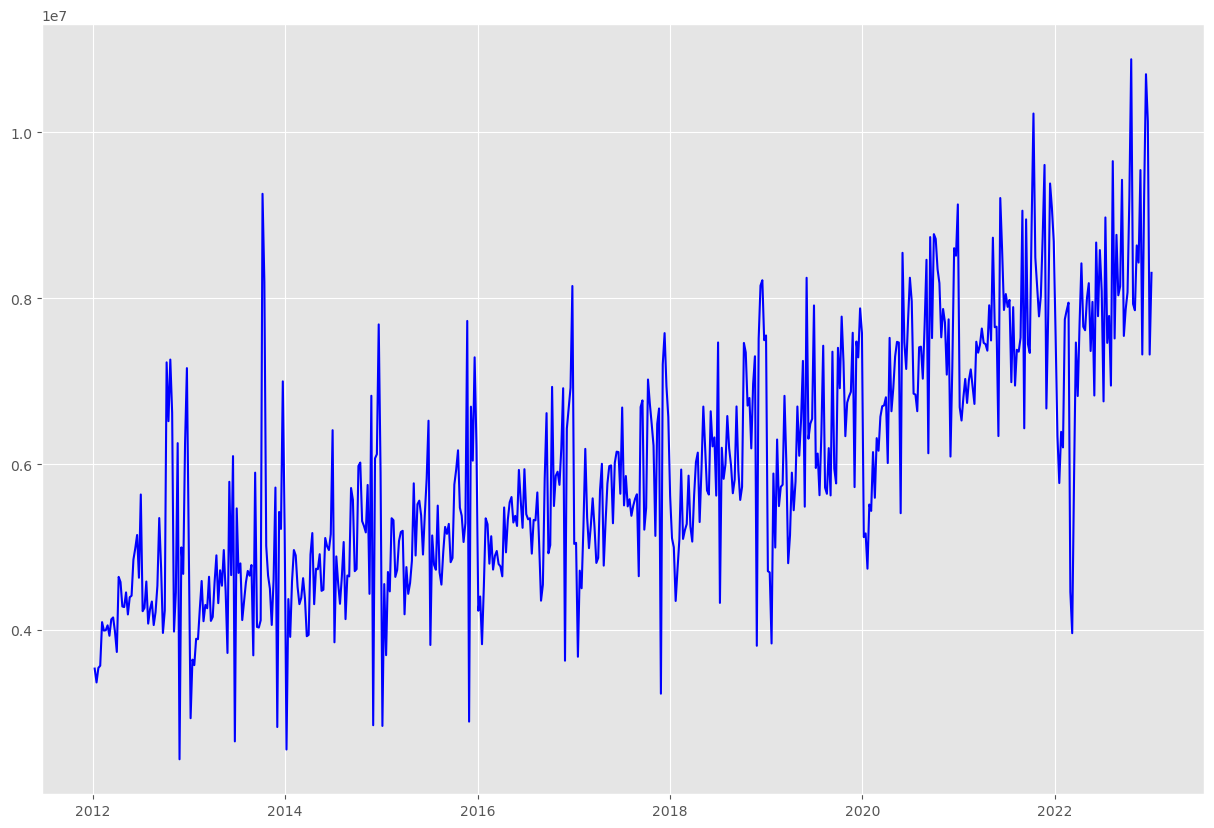

In [24]:
# inspect there's any trend of the sales total during these years.
plt.figure(figsize=(15,10))
plt.plot(IowaSales_Resampled["Date"], IowaSales_Resampled["Sale (Dollars)"], color='blue')

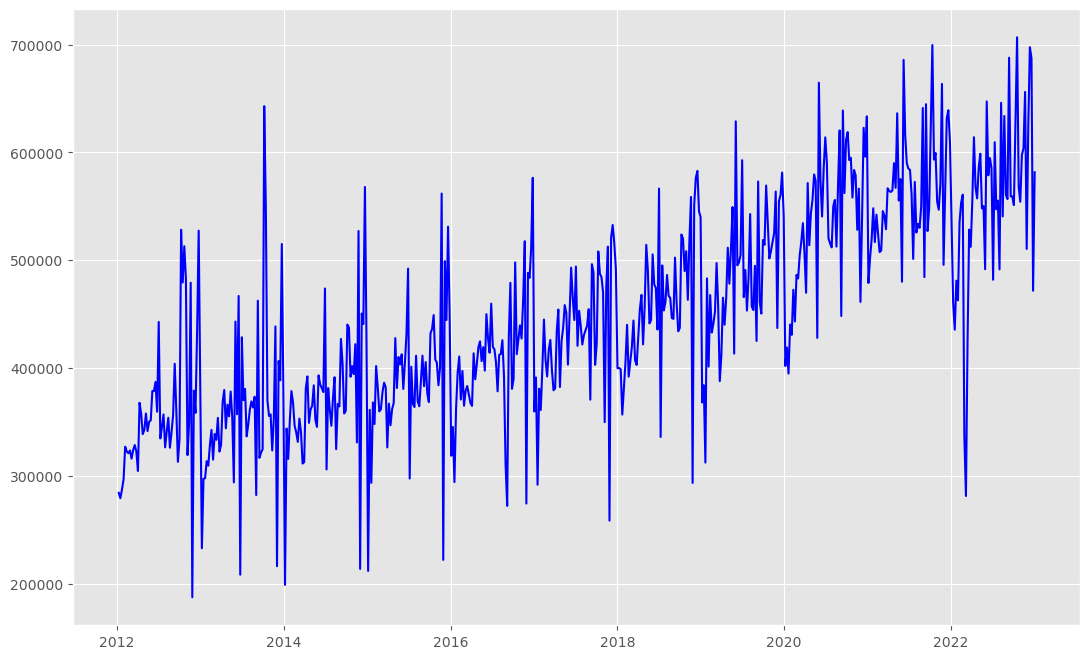

In [25]:
# Inspect if there's any trend of "bottles Sold" during these years.
plt.plot(IowaSales_Resampled["Date"], IowaSales_Resampled["Bottles Sold"], color='blue')

In [38]:
# generate the rolling of total sale and smooth the curve.
window = 14
rolling_sum = IowaSales_Resampled_ByDay["Sale (Dollars)"].rolling(window).sum()
rolling_avg = (rolling_sum / window)[window-1:]
IowaSales_Resampled_WithRollAvg = IowaSales_Resampled_ByDay[window:]
IowaSales_Resampled_WithRollAvg["Sale Days (Dollars)"] = rolling_avg[:]

C:\Users\tirth\AppData\Local\Temp\ipykernel_19300\2754996783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IowaSales_Resampled_WithRollAvg["Sale Days (Dollars)"] = rolling_avg[:]


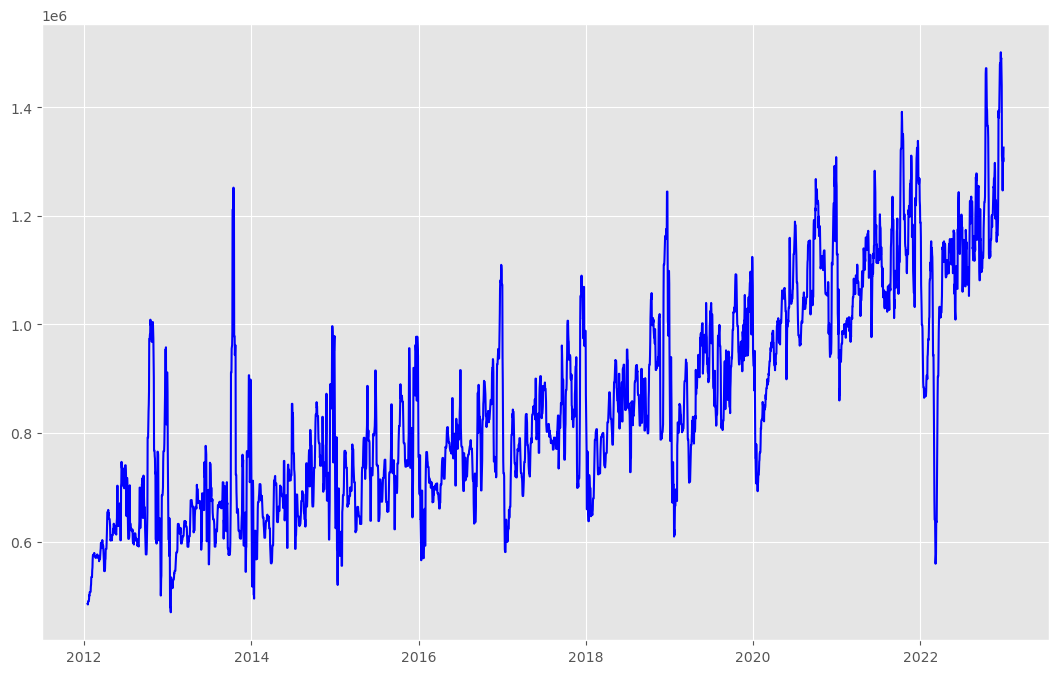

In [42]:
plt.plot(IowaSales_Resampled_WithRollAvg["Date"], IowaSales_Resampled_WithRollAvg["Sale Days (Dollars)"], color='blue')

In [43]:
IowaSales_Resampled.shape, IowaSales_Resampled_ByDay.shape, IowaSales_Resampled_WithRollAvg.shape
# plt.figure(figsize=(15,10))
# sns.heatmap(IowaSales_Reduced.iloc[:, 1:].corr(), center=0);

((574, 127), (4015, 127), (4001, 128))

In [44]:
IowaSales_Resampled_WithRollAvg.head(8)

,Date,Pack,Bottle Volume (ml),State Bottle Cost,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Latitude,Month,Pack Volume (ml),...,County Number_91.0,County Number_92.0,County Number_93.0,County Number_94.0,County Number_95.0,County Number_96.0,County Number_97.0,County Number_98.0,County Number_99.0,Sale Days (Dollars)
14,2012-01-17,101632,8061000,73525.40,68091,842912.95,66453.73,349581.720541,8354,79433600,...,97.0,9.0,0.0,0.0,70.0,0.0,0.0,0.0,47.0,485706.536429
15,2012-01-18,86669,6937728,63562.57,64226,811725.39,64060.86,301044.385524,7178,67952644,...,17.0,139.0,0.0,389.0,0.0,0.0,160.0,0.0,75.0,484431.140000
16,2012-01-19,100719,7037878,67726.60,79211,947073.96,71123.01,326499.458280,7815,71553730,...,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490269.047857
17,2012-01-20,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490269.047857
18,2012-01-21,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490269.047857
19,2012-01-22,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490269.047857
20,2012-01-23,90501,7458477,70034.17,75757,941721.27,70113.54,324572.582565,7670,72934020,...,0.0,0.0,59.0,29.0,29.0,156.0,744.0,32.0,29.0,493717.139286
21,2012-01-24,101899,8371852,76714.94,75534,949654.05,75030.12,359587.974260,8589,81872840,...,73.0,8.0,0.0,0.0,81.0,0.0,0.0,0.0,46.0,501644.032857


In [45]:
# Remove dummy data - whole row with 0
IowaSales_Cleaned = IowaSales_Resampled_WithRollAvg.drop(['Sale (Dollars)'], axis=1)
IowaSales_Cleaned.shape

(4001, 127)

# LSTM #

In [46]:
# 80~20 - training set splitting.
TRAIN_SPLIT = int(len(IowaSales_Cleaned) * 0.8)
TRAIN_SPLIT

3200

In [47]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []

    start_index = (start_index + history_size) if start_index < history_size else start_index
    if end_index is None:
        end_index = len(dataset) - target_size
   
    for i in range(start_index, end_index):
        if ((i + step) >= end_index or i >= end_index): 
            break
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [48]:
def standardize(dataset, training_size):
    data_mean = dataset[:training_size].mean(axis=0)
    data_std = dataset[:training_size].std(axis=0)
    dataset_standardized = (dataset-data_mean)/data_std
    return dataset_standardized, data_mean, data_std

In [49]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [50]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, mean, std):
    plt.figure(figsize=(12, 6))
    
    num_in = create_time_steps(len(history))    
    num_out = len(true_future)

    hist_pos = history.shape[1] - 1;    
    invert_history = history * std + mean    
    
    plt.plot(num_in, np.array(invert_history[:, hist_pos]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r--', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [51]:
def setup_model(X, target_size, n_neurons): 

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(n_neurons[0], return_sequences=True, input_shape=X.shape[-2:]))
    model.add(tf.keras.layers.LSTM(n_neurons[1], activation='relu'))
    model.add(tf.keras.layers.Dense(target_size))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    
    return model

In [52]:
y_data = IowaSales_Cleaned["Sale Days (Dollars)"].values
X_data = IowaSales_Cleaned.drop(['Date'], axis=1).values
X_data_norm, X_data_mean, X_data_std = standardize(X_data, TRAIN_SPLIT)

In [53]:
X_data.shape, IowaSales_Cleaned.shape, IowaSales_Cleaned.columns[:].to_list()

((4001, 126),
 (4001, 127),
 ['Date',
  'Pack',
  'Bottle Volume (ml)',
  'State Bottle Cost',
  'Bottles Sold',
  'Volume Sold (Liters)',
  'Latitude',
  'Month',
  'Pack Volume (ml)',
  'Category Name_ANISETTE',
  'Category Name_BEER',
  'Category Name_BRANDIES',
  'Category Name_COCKTAIL',
  'Category Name_CORDIALS & LIQUEURS',
  'Category Name_DELISTED / SPECIAL ORDER ITEMS',
  'Category Name_GINS',
  'Category Name_IOWA DISTILLERIES',
  'Category Name_MEZCAL',
  'Category Name_OTHERS',
  'Category Name_ROCK & RYE',
  'Category Name_RUM',
  'Category Name_SCHNAPPS',
  'Category Name_SCOTCH',
  'Category Name_SPECIAL ORDER ITEMS',
  'Category Name_SPIRIT SPECIALTY',
  'Category Name_TEQUILA',
  'Category Name_VODKA',
  'Category Name_WHISKY',
  'County Number_2.0',
  'County Number_3.0',
  'County Number_4.0',
  'County Number_5.0',
  'County Number_6.0',
  'County Number_7.0',
  'County Number_8.0',
  'County Number_9.0',
  'County Number_10.0',
  'County Number_11.0',
  'County Nu

In [54]:
X_train, y_train = multivariate_data(X_data_norm, y_data, 0,
                                     TRAIN_SPLIT, past_history,
                                     future_target, STEP)
X_val, y_val = multivariate_data(X_data_norm, y_data,
                                 TRAIN_SPLIT, None, past_history,
                                 future_target, STEP)

In [55]:
print ('Single window of past history : {}'.format(X_train[0].shape))
print ('\n Target to predict : {}'.format(y_train[0].shape))

Single window of past history : (60, 126)

 Target to predict : (60,)


In [56]:
train_data_slices = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_slices = train_data_slices.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_slices = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data_slices = val_data_slices.batch(BATCH_SIZE).repeat()

In [57]:
train_data_slices,val_data_slices,X_val.shape

(<RepeatDataset element_spec=(TensorSpec(shape=(None, 60, 126), dtype=tf.float64, name=None), TensorSpec(shape=(None, 60), dtype=tf.float64, name=None))>,
 <RepeatDataset element_spec=(TensorSpec(shape=(None, 60, 126), dtype=tf.float64, name=None), TensorSpec(shape=(None, 60), dtype=tf.float64, name=None))>,
 (735, 60, 126))

In [58]:
lstm = setup_model(X_train, future_target, n_neurons)

In [59]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            20352     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 60)                1020      
                                                                 
Total params: 24,508
Trainable params: 24,508
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Quick look of the output structure
for x, y in val_data_slices.take(1):
    print('1', lstm.predict(x).shape)


8/8 [==============================] - 0s 6ms/step
1 (256, 60)


In [61]:
multi_out = lstm.fit(train_data_slices, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data_slices,
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 14s 60ms/step - loss: 669710.0000 - val_loss: 341832.0000
Epoch 2/10
200/200 [==============================] - 11s 56ms/step - loss: 170423.8125 - val_loss: 282305.0938
Epoch 3/10
200/200 [==============================] - 11s 55ms/step - loss: 123379.1406 - val_loss: 208775.2812
Epoch 4/10
200/200 [==============================] - 11s 56ms/step - loss: 115725.0391 - val_loss: 184832.3750
Epoch 5/10
200/200 [==============================] - 11s 57ms/step - loss: 114589.0625 - val_loss: 175803.5625
Epoch 6/10
200/200 [==============================] - 11s 55ms/step - loss: 113388.7500 - val_loss: 162274.2031
Epoch 7/10
200/200 [==============================] - 11s 56ms/step - loss: 112443.6328 - val_loss: 153753.0156
Epoch 8/10
200/200 [==============================] - 11s 55ms/step - loss: 113495.8984 - val_loss: 147125.7969
Epoch 9/10
200/200 [==============================] - 11s 56ms/step - loss: 112828.9844 - val_loss: 1387

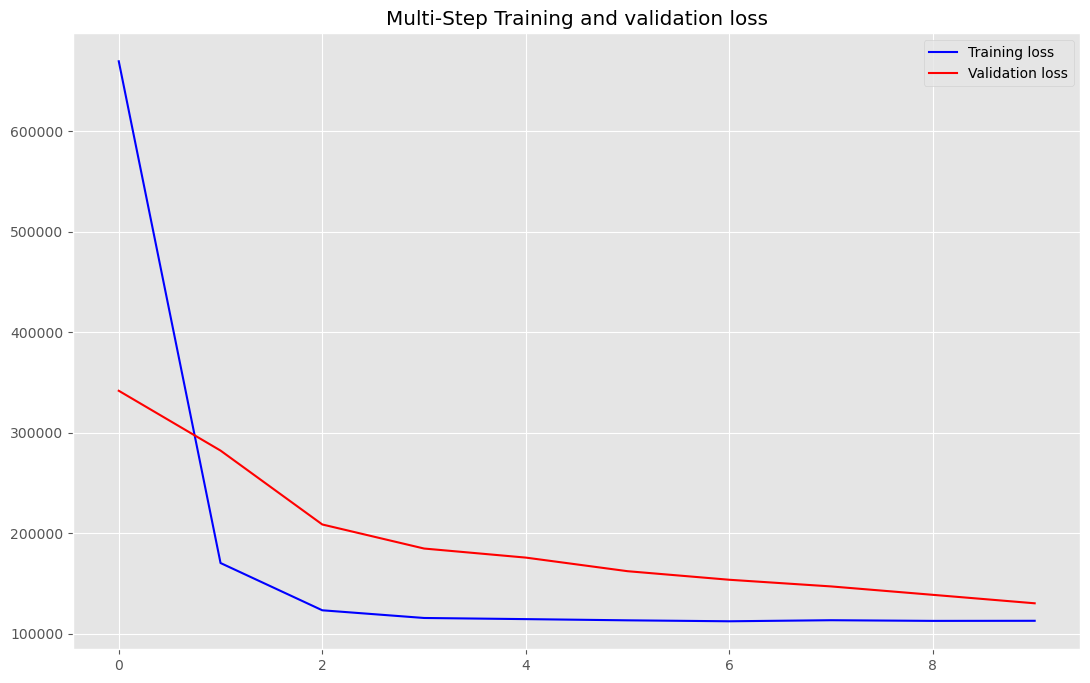

In [62]:
plot_train_history(multi_out, 'Multi-Step Training and validation loss')

In [63]:
X_data.shape

(4001, 126)

8/8 [==============================] - 0s 6ms/step


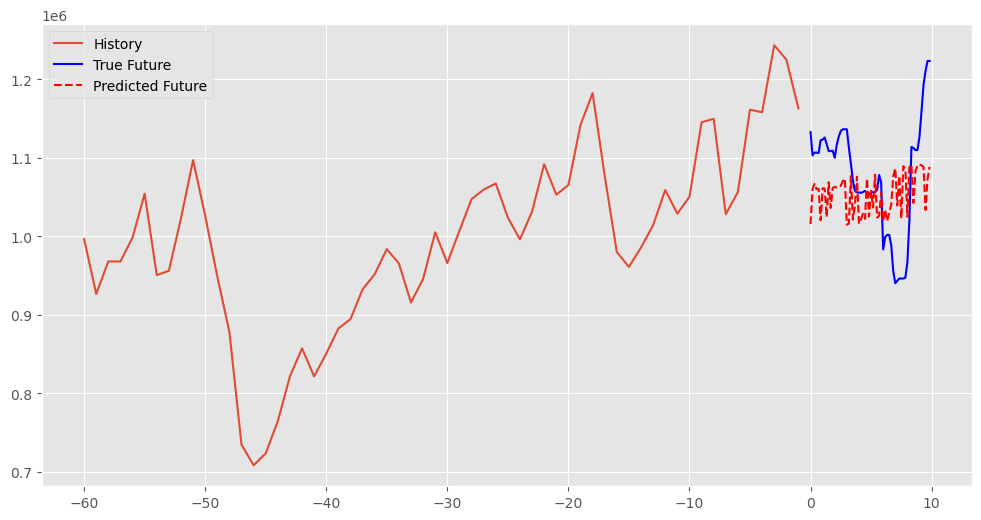

8/8 [==============================] - 0s 6ms/step


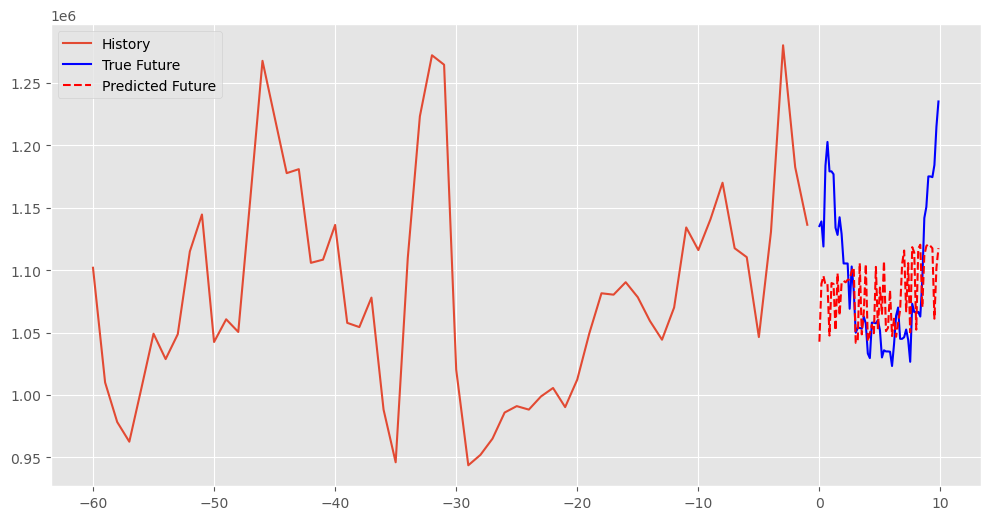

7/7 [==============================] - 0s 6ms/step


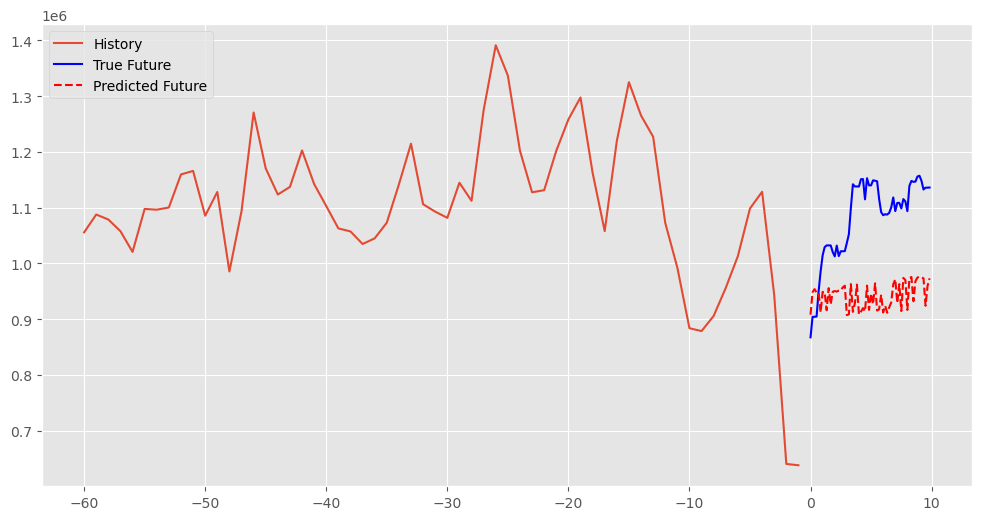

8/8 [==============================] - 0s 6ms/step


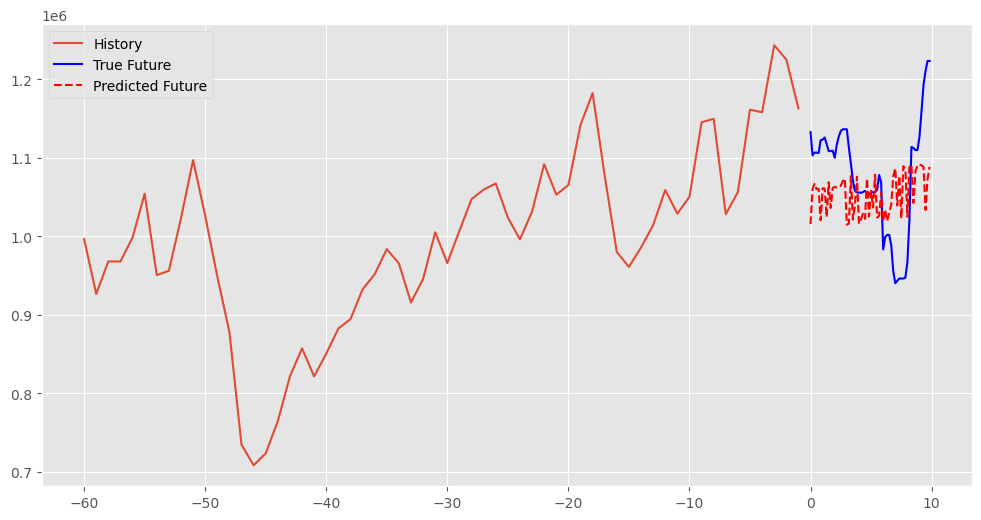

8/8 [==============================] - 0s 6ms/step


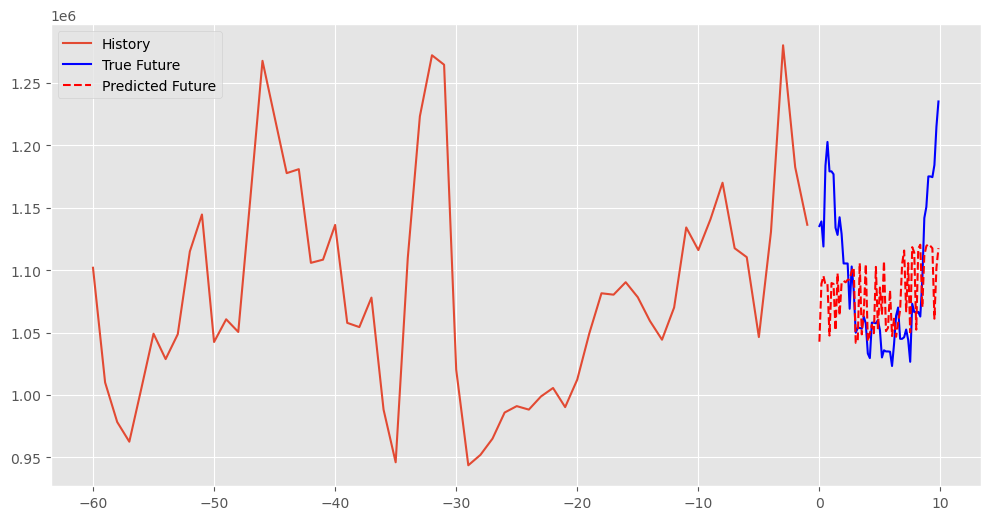

7/7 [==============================] - 0s 6ms/step


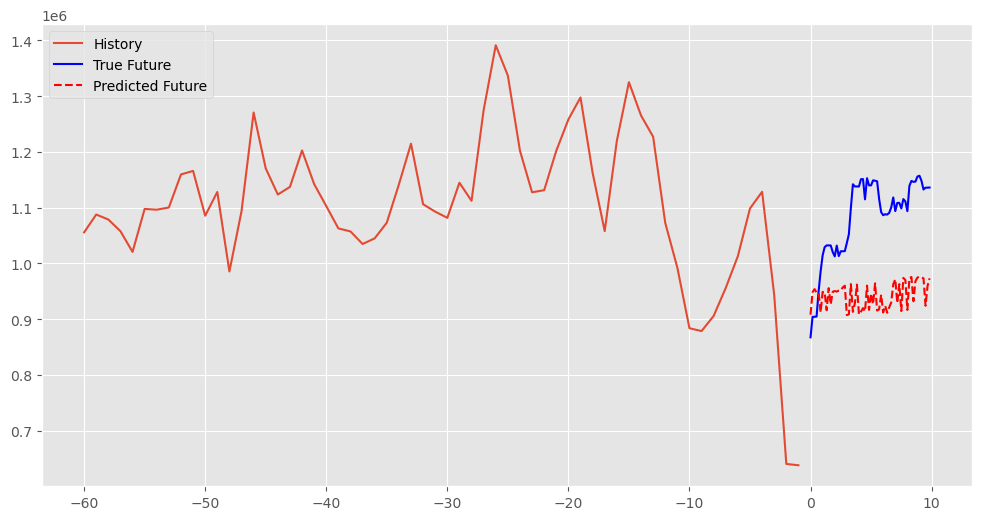

8/8 [==============================] - 0s 6ms/step


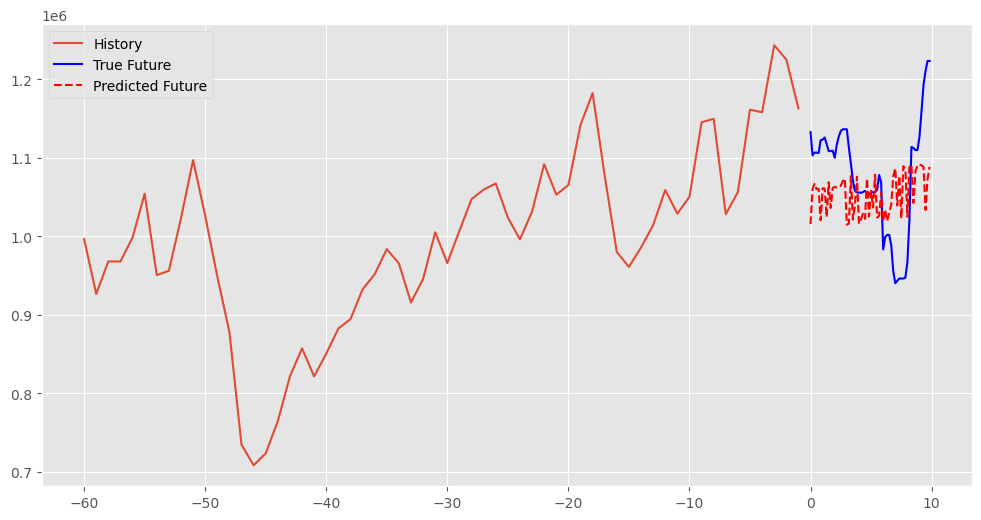

8/8 [==============================] - 0s 6ms/step


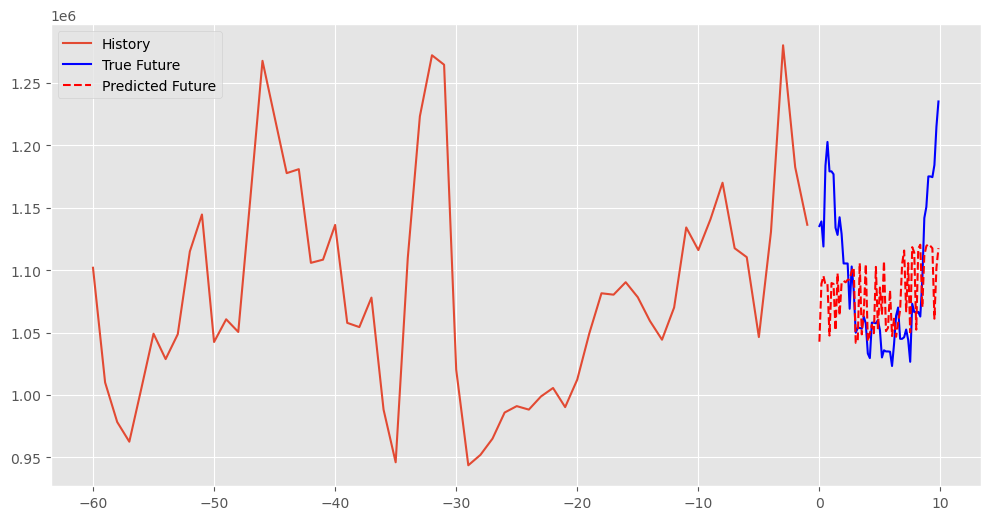

7/7 [==============================] - 0s 6ms/step


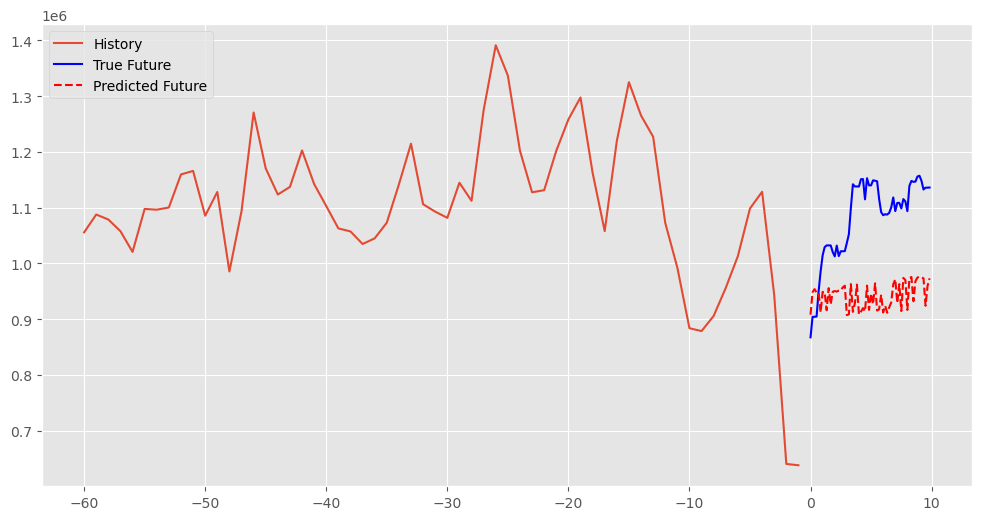

8/8 [==============================] - 0s 6ms/step


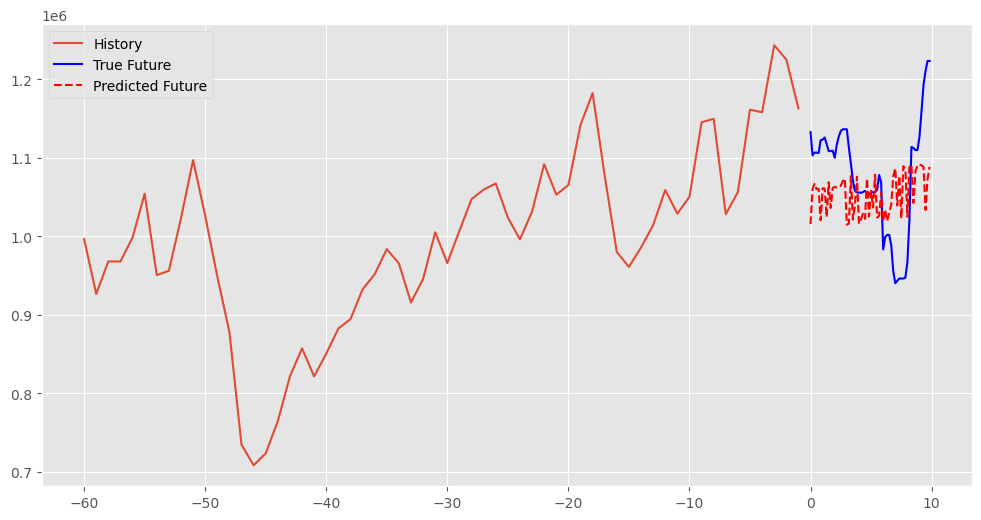

8/8 [==============================] - 0s 6ms/step


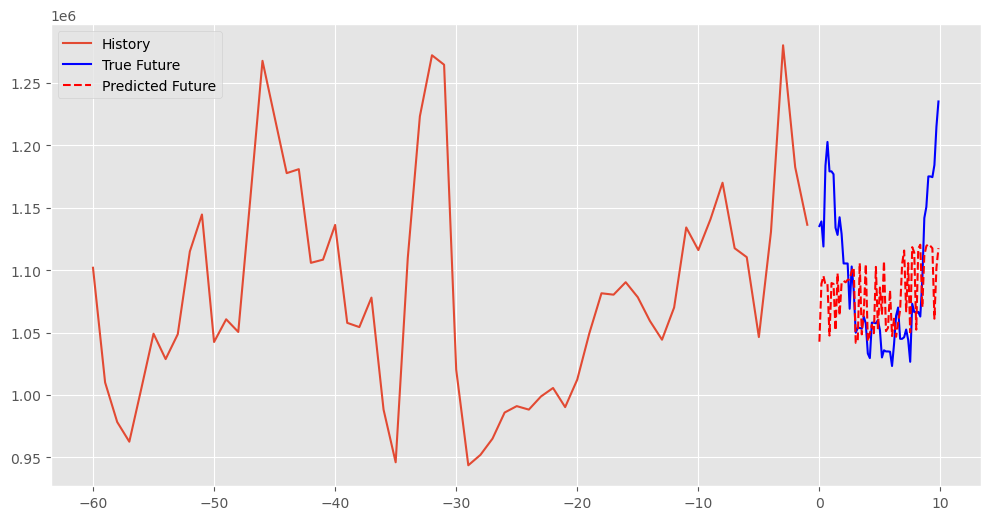

7/7 [==============================] - 0s 6ms/step


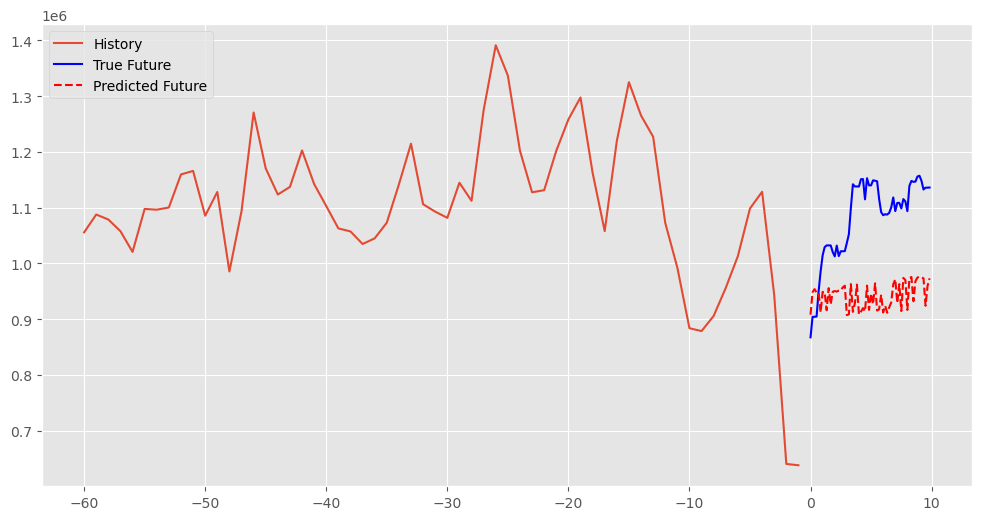

8/8 [==============================] - 0s 6ms/step


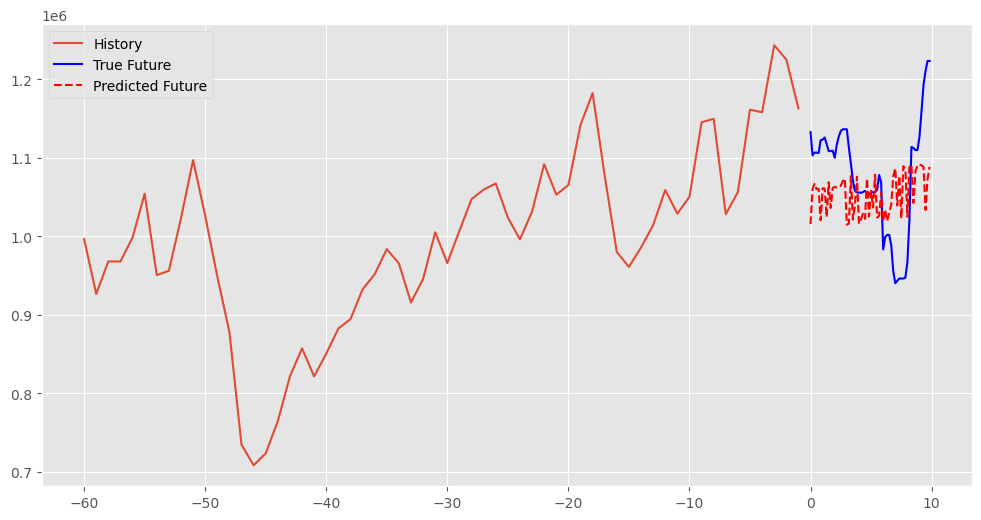

8/8 [==============================] - 0s 6ms/step


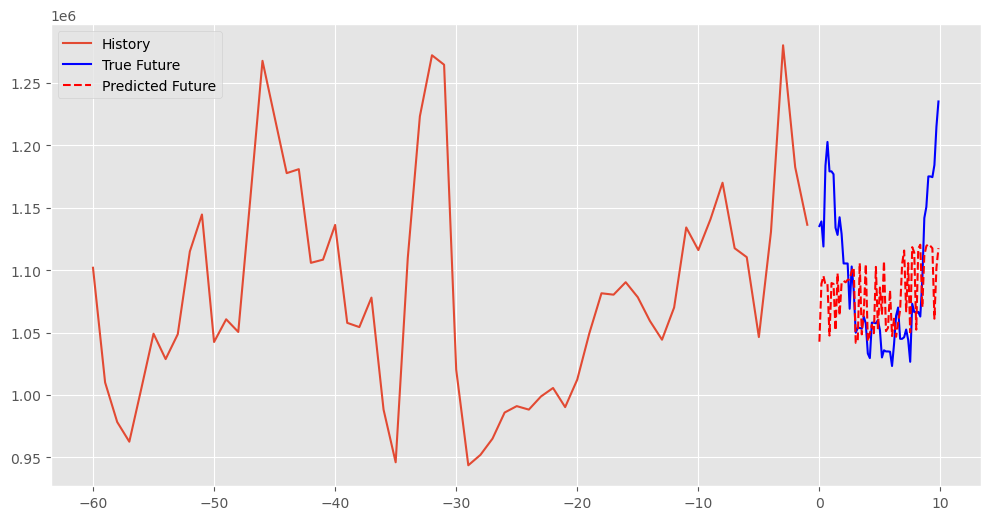

7/7 [==============================] - 0s 5ms/step


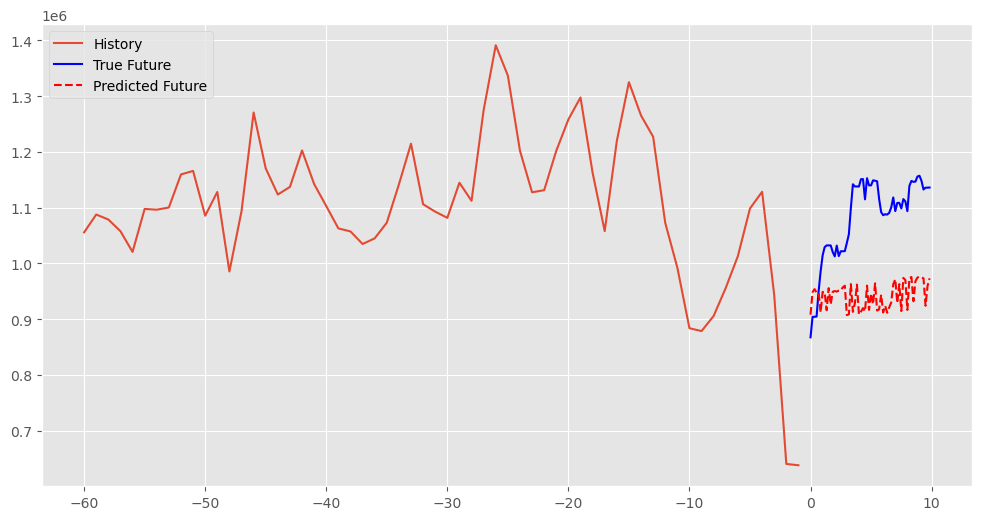

8/8 [==============================] - 0s 6ms/step


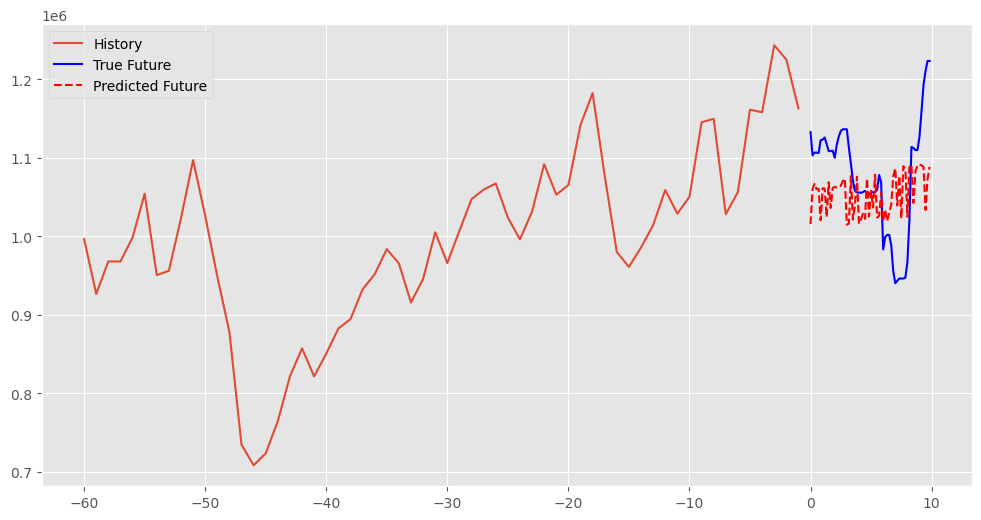

8/8 [==============================] - 0s 6ms/step


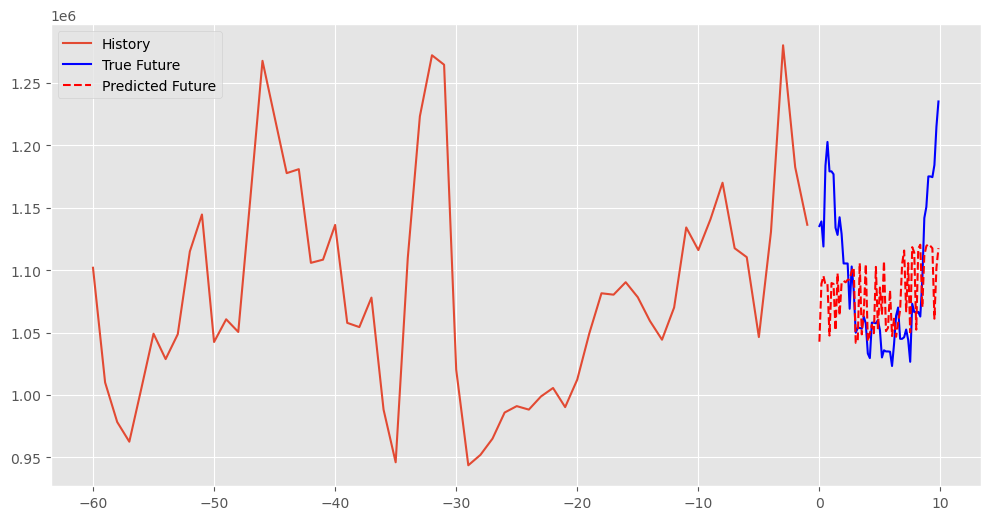

7/7 [==============================] - 0s 5ms/step


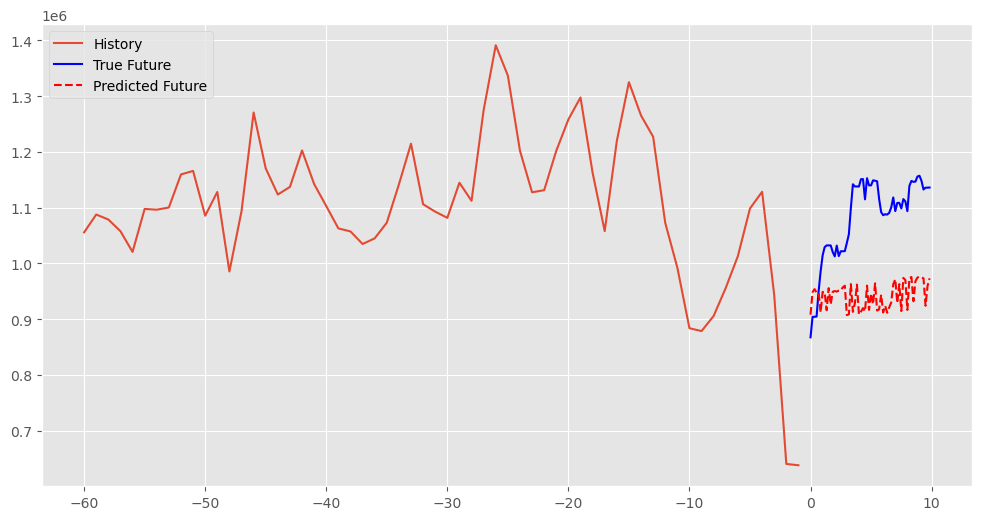

8/8 [==============================] - 0s 6ms/step


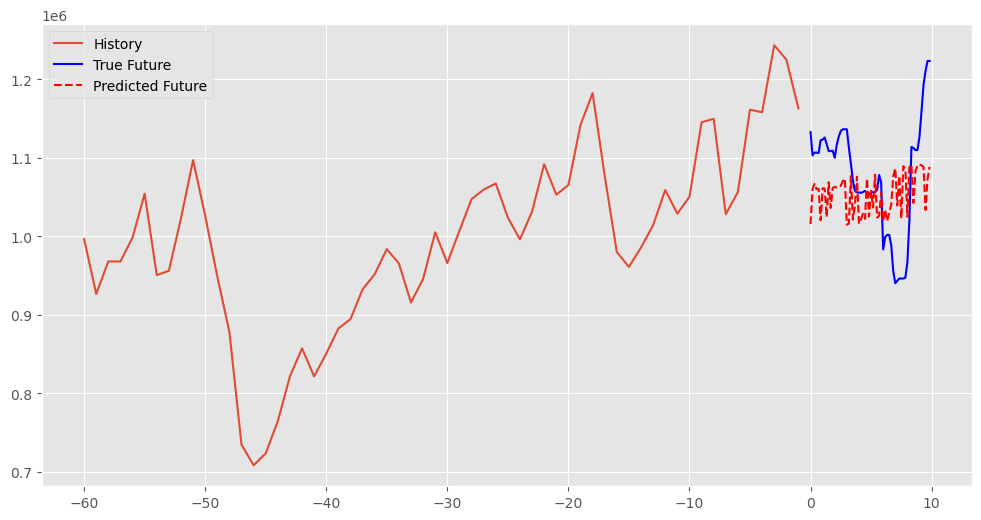

8/8 [==============================] - 0s 6ms/step


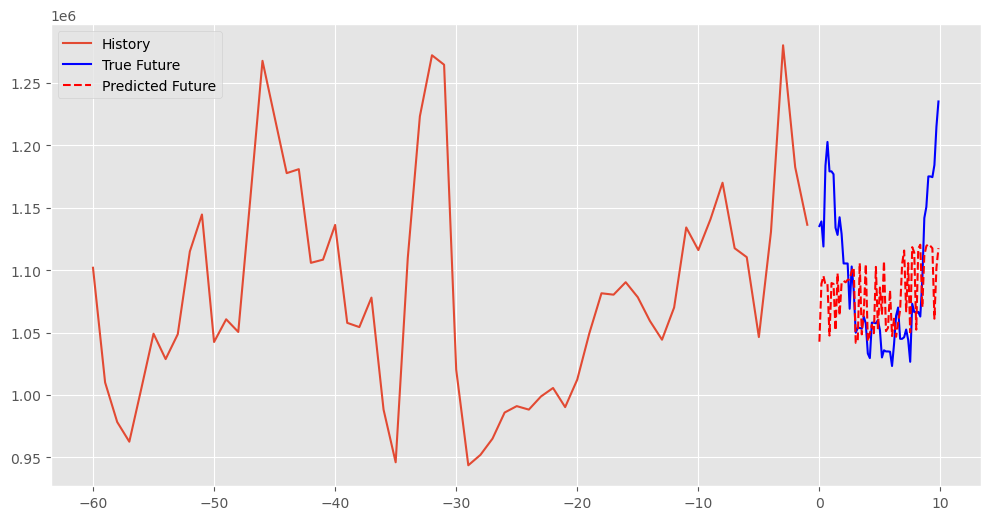

In [64]:
# print(X_val[:1])

for x, y in val_data_slices.take(20):
    multi_step_plot(x[0], y[0], lstm.predict(x)[0], X_data_mean, X_data_std)

8/8 [==============================] - 0s 6ms/step


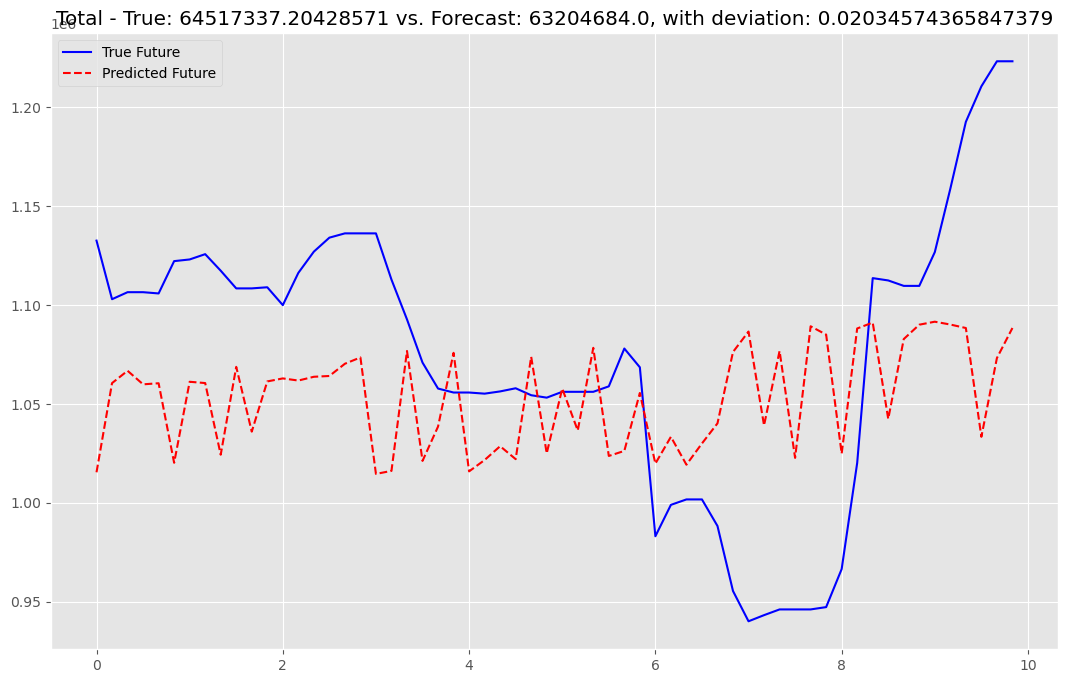

8/8 [==============================] - 0s 6ms/step


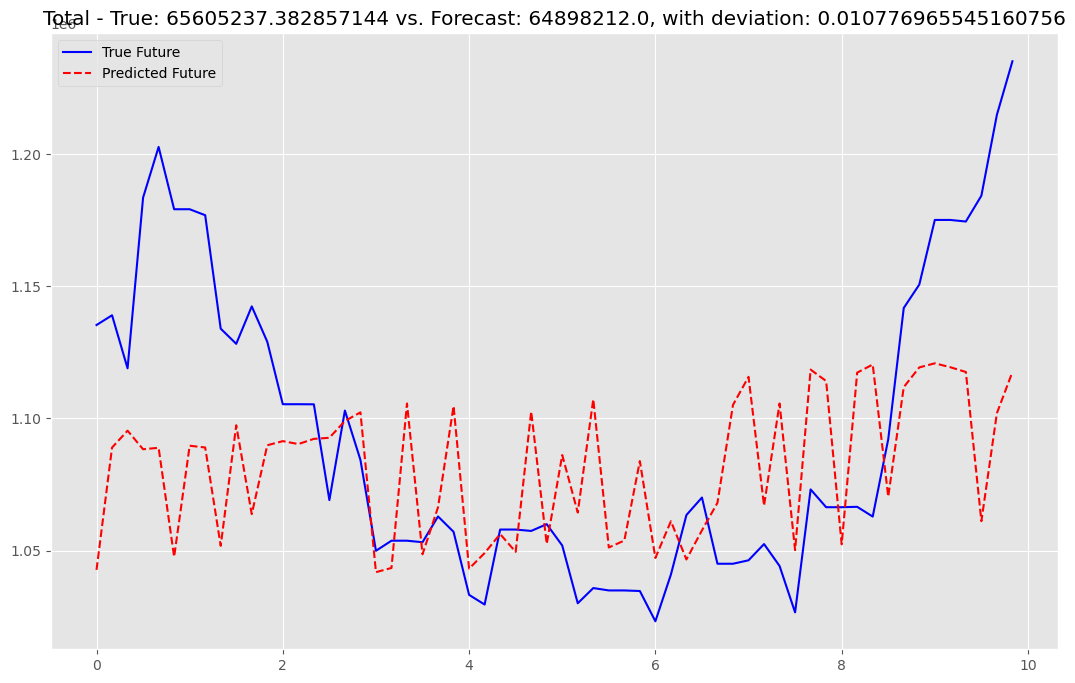

7/7 [==============================] - 0s 5ms/step


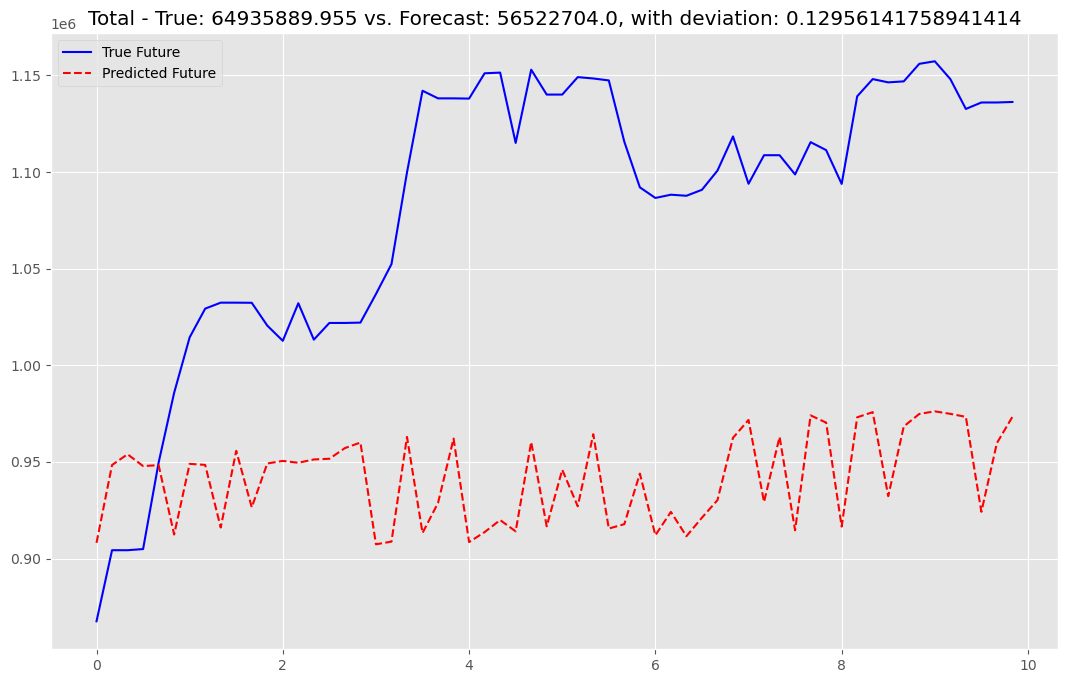

8/8 [==============================] - 0s 6ms/step


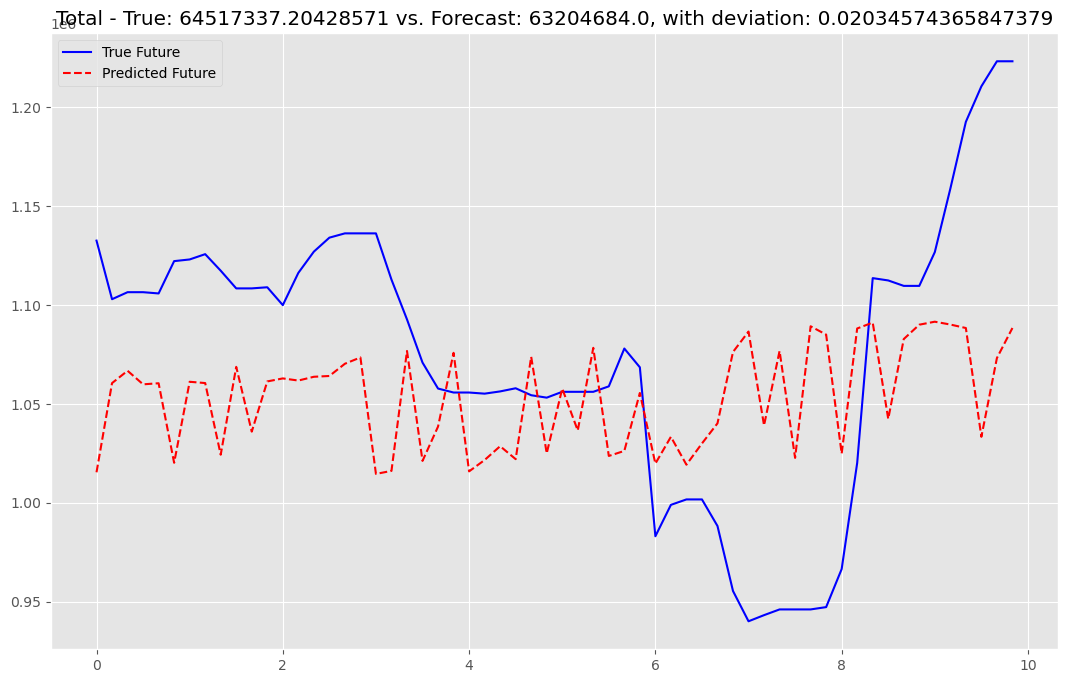

8/8 [==============================] - 0s 5ms/step


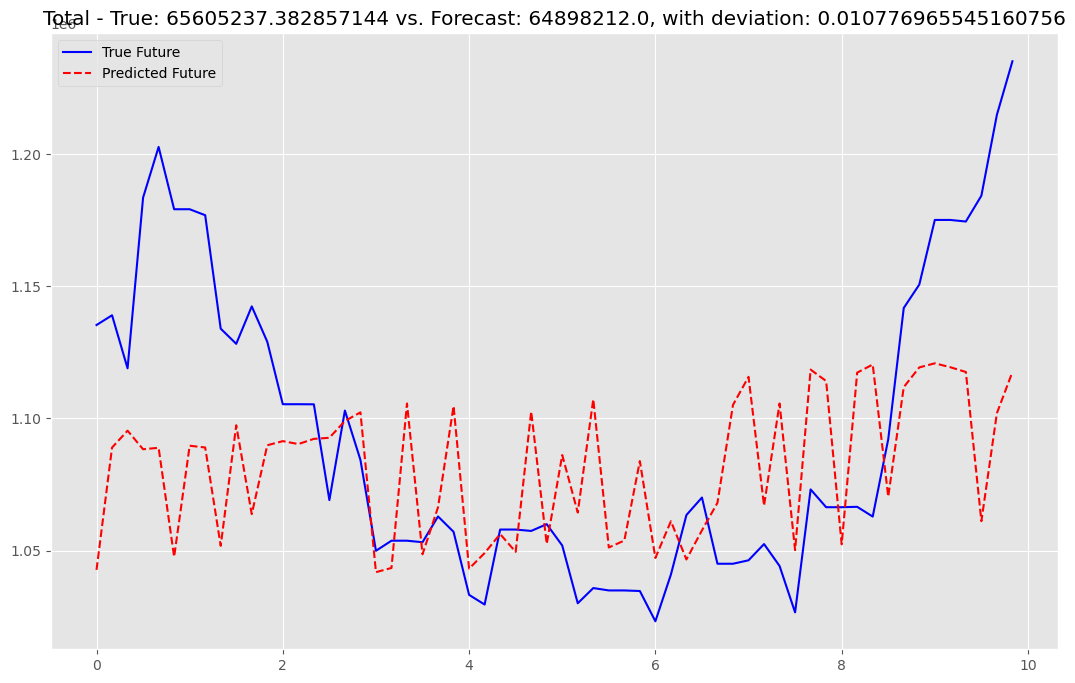

8/8 [==============================] - 0s 6ms/step
Overall accuracy mean: 0.949760187596238 (i.e. inaccuracy mean: 0.050239812403761984), Deviation: 0.0520790950178992 for sampled 10 forecasting.


In [66]:
deviations = list()
plot_limit = 5
for x, y in val_data_slices.take(10):
    true_future = y[0]
    predict_future = lstm.predict(x)[0]
    mean, std = X_data_mean, X_data_std    
    future_num = np.arange(len(true_future))/STEP   
    
    t_sum = np.sum(true_future)
    p_sum = np.sum(predict_future)
    dev = np.absolute((p_sum - t_sum)/t_sum)
    
    if plot_limit > 0: 
        plt.plot(future_num, np.array(true_future), 'b-', label='True Future')
        plt.plot(future_num, np.array(predict_future), 'r--', label='Predicted Future')
        plt.legend(loc='upper left')
        plot_limit = plot_limit - 1
        plt.title(F"Total - True: {t_sum} vs. Forecast: {p_sum}, with deviation: {dev}")
        plt.show()
    
    deviations.append(dev)  
    
dev_mean = np.mean(deviations)
dev_std = np.std(deviations)
print(F"Overall accuracy mean: { 1 - dev_mean} (i.e. inaccuracy mean: {dev_mean}), Deviation: {dev_std} for sampled {len(deviations)} forecasting.")
